In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gnninterpreter import *

In [3]:
import torch
from torch import nn

# Shape

In [4]:
dataset = ShapeDataset(seed=12345)

In [5]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=4)

In [6]:
model.load_state_dict(torch.load('ckpts/shape.pt'))

<All keys matched successfully>

In [7]:
dataset.evaluate_model(model)

/opt/homebrew/Caskroom/mambaforge/base/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


{'random': 0.9814640283584595,
 'lollipop': 0.9847187995910645,
 'wheel': 0.9916589260101318,
 'grid': 0.9788162112236023,
 'star': 1.0}

In [8]:
mean_embeds = dataset.mean_embeddings(model)

In [9]:
trainer = {}
sampler = {}

# Lollipop

In [14]:
classes = 1
sampler[classes] = s = GraphSampler(max_nodes=25,
                                    temperature=0.15,
                                    learn_node_feat=False)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=15), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                  discriminator=model,
                  criterion=criterion,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  dataset=dataset,
                  k_samples=16)

In [15]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9


In [16]:
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [17]:
trainer[1].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=23 m=24
logits=[-4.419562816619873, 0.9677745699882507, -28.28148078918457, -5.010132789611816, -143.8326873779297]
probs=[0.0045418525114655495, 0.9929418563842773, 1.9684902037402086e-13, 0.0025162380188703537, 0.0]


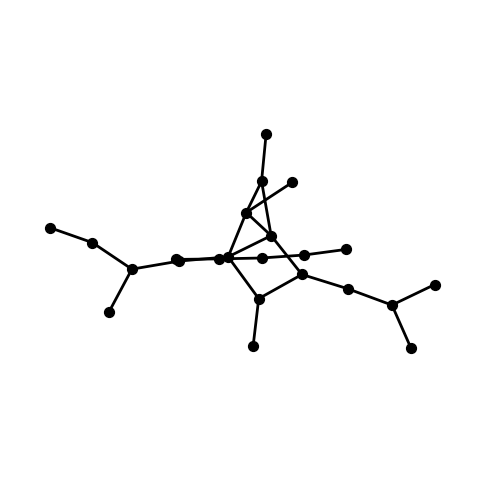

In [19]:
trainer[1].evaluate(threshold=0.5, show=True)

# Wheel

In [21]:
classes = 2
sampler[classes] = s = GraphSampler(max_nodes=25,
                                    temperature=0.15,
                                    learn_node_feat=False)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=10), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [22]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9

def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [24]:
trainer[2].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=22 m=24
logits=[-20.861127853393555, -66.88731384277344, -5.212587833404541, -96.18472290039062, -11.704874038696289]
probs=[1.5968630862062128e-07, 1.6381357290885235e-27, 0.998487114906311, 3.0948797623385045e-40, 0.0015127891674637794]


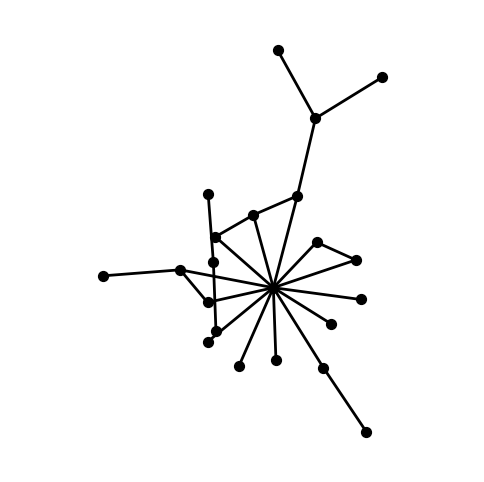

In [25]:
trainer[2].evaluate(threshold=0.5, show=True)

# Grid

In [29]:
classes = 3
sampler[classes] = s = GraphSampler(max_nodes=25,
                                    temperature=0.15,
                                    learn_node_feat=False)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=10),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=20), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [30]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [31]:
trainer[3].train(2000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=23 m=25
logits=[-6.079453468322754, -10.491562843322754, -36.03765106201172, 4.285440444946289, -170.6971435546875]
probs=[3.151881537633017e-05, 3.8230953691709146e-07, 3.0753235142129233e-18, 0.9999680519104004, 0.0]


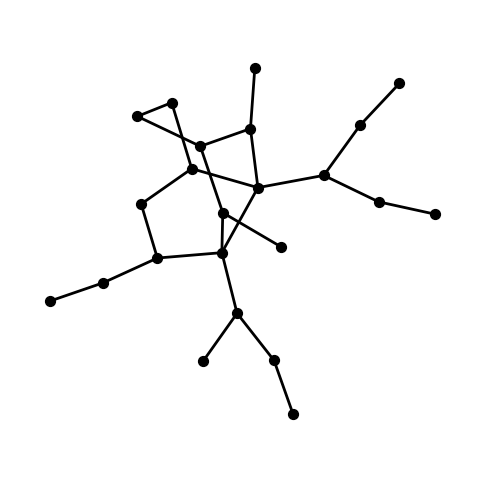

In [32]:
trainer[3].evaluate(threshold=0.5, show=True)

# Star

In [34]:
classes = 4
sampler[classes] = s = GraphSampler(max_nodes=20,
                                    temperature=0.15,
                                    learn_node_feat=False)

criterion = nn.Sequential(
    WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=classes), mode="maximize", weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[classes]), weight=5),
    ]),
    NormPenalty(lambda: s.omega, order=1, weight=1), # L1 penalty on omega, encourage uncertainty
    NormPenalty(lambda: s.omega, order=2, weight=1), # L2 penalty on omega, avoid extreme probabilities
    # NormPenalty(lambda: s.xi, order=1, weight=0), # L1 penalty on xi
    # NormPenalty(lambda: s.xi, order=2, weight=0), # L2 penalty on xi
    budget := BudgetPenalty(lambda: s.theta, budget=10, order=2, beta=0.5, weight=1), # Budget penalty on theta, encourage sparsity
    CrossEntropyPenalty(lambda: s.theta, weight=0), # Element-wise entropy penalty on theta, encourage discreteness
    KLDivergencePenalty(lambda: tuple(s.theta_pairs), binary=True, weight=10), # Pair-wise cross entropy on E, encourage connectivity
)
optimizer = torch.optim.SGD(s.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1)

# construct graph sampler trainer
trainer[classes] = Trainer(sampler=s,
                           discriminator=model,
                           criterion=criterion,
                           optimizer=optimizer,
                           scheduler=scheduler,
                           dataset=dataset,
                           k_samples=16)

In [35]:
def penalty_cond(out, trainer, boundary_cls=classes):
    return out["probs"][0, classes].item() > 0.9
    
def break_cond(out, trainer, boundary_cls=classes):
    return all([
        penalty_cond(out, trainer, boundary_cls),
        trainer.sampler.expected_m < 30
    ])

In [36]:
trainer[4].train(5000, dynamic_penalty=budget, penalty_cond=penalty_cond, break_cond=break_cond)

  0%|          | 0/5000 [00:00<?, ?it/s]

True

n=20 m=29
logits=[-17.261682510375977, -66.1810531616211, -14.188146591186523, -82.38772583007812, -7.8946146965026855]
probs=[8.532874926459044e-05, 4.849339990761838e-26, 0.0018446537433192134, 4.438273980123386e-33, 0.9980700612068176]


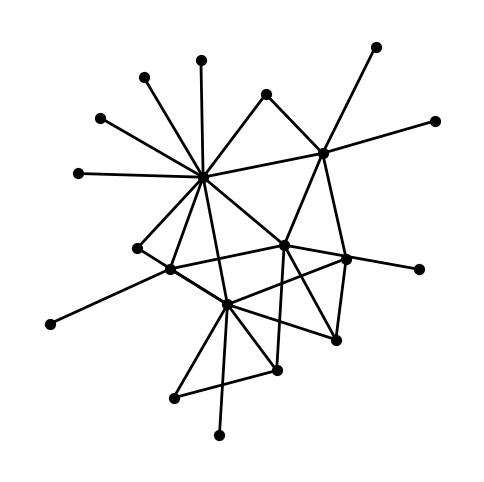

In [37]:
trainer[4].evaluate(threshold=0.5, show=True)